<a href="https://colab.research.google.com/github/mmsamiei/lets-pytorch/blob/master/Q7_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [0]:
# MNIST Dataset
original_train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
original_test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=True)

In [0]:
CUDA = True
BATCH_SIZE = 64

In [0]:
# Define Train loader
train_tensors = (original_train_dataset.data.float() / 255)
test_tensors = (original_test_dataset.data.float() / 255)

train_dataset = torch.utils.data.TensorDataset(train_tensors, original_train_dataset.targets)
test_dataset = torch.utils.data.TensorDataset(test_tensors, original_test_dataset.targets)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [0]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 2, 3, stride = 2)
        self.conv2 = nn.Conv2d(2, 4, 3, stride = 2)
        self.conv3 = nn.Conv2d(4, 4, 3, stride = 2)
        self.lrelu = nn.LeakyReLU(0.2)
        self.lin = nn.Linear(16, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        temp = x.view(-1, 1, 28, 28)
        temp = self.conv1(temp)
        temp = self.lrelu(temp)
        temp = self.conv2(temp)
        temp = self.lrelu(temp)
        temp = self.conv3(temp)
        temp = self.lrelu(temp)
        temp = temp.view(-1, 16)
        temp = self.lin(temp)
        out = self.sigmoid(temp)
        return out

In [0]:
class Generator(nn.Module):
  def __init__(self):
    super().__init__()
    self.deconv1 = nn.ConvTranspose2d(1, 16, 5)
    self.deconv1_bn = nn.BatchNorm2d(16)
    self.deconv2 = nn.ConvTranspose2d(16, 8, 5)
    self.deconv1_bn = nn.BatchNorm2d(8)
    self.deconv3 = nn.ConvTranspose2d(8, 4, 5)
    self.deconv1_bn = nn.BatchNorm2d(4)
    self.deconv4 = nn.ConvTranspose2d(4, 2, 5)
    self.deconv1_bn = nn.BatchNorm2d(2)
    self.deconv5 = nn.ConvTranspose2d(2, 1, 3) 
    
  # x must be 100
  def forward(self, x):
    temp = x.view(-1, 1, 10, 10)
    temp = self.deconv1(temp)
    temp = self.deconv2(temp)
    temp = self.deconv3(temp)
    temp = self.deconv4(temp)
    temp = self.deconv5(temp)
    return temp

In [0]:
discriminator = Discriminator()
generator = Generator()

In [0]:
if CUDA:
  discriminator.cuda()
  generator.cuda()

In [0]:
LEARNING_RATE_D = 0.0002
LEARNING_RATE_G = 0.0002


opt_D = optim.Adam(discriminator.parameters(), lr=LEARNING_RATE_D)
opt_G = optim.Adam(generator.parameters(), lr=LEARNING_RATE_G)

In [0]:
N_EPOCH = 100

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 3) # set default size of plots

epoch: 0 	 last batch loss D: 1.3839547634124756 	 last batch loss G: 0.6711870431900024


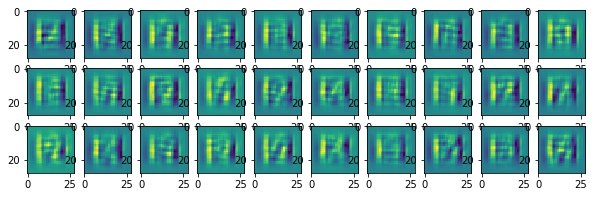

epoch: 1 	 last batch loss D: 1.38677978515625 	 last batch loss G: 0.6983761787414551


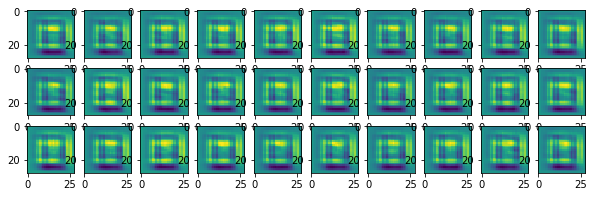

epoch: 2 	 last batch loss D: 1.3834261894226074 	 last batch loss G: 0.7016776204109192


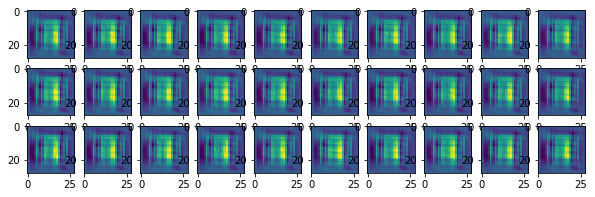

epoch: 3 	 last batch loss D: 1.3856797218322754 	 last batch loss G: 0.6931538581848145


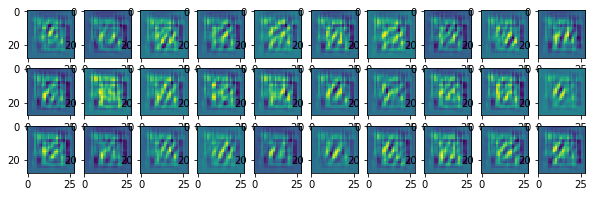

epoch: 4 	 last batch loss D: 1.386408805847168 	 last batch loss G: 0.6923896074295044


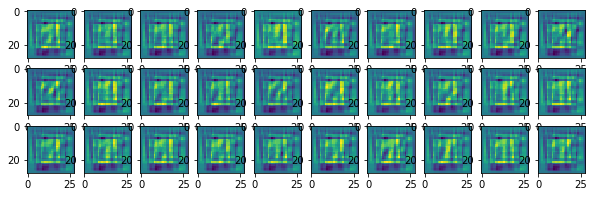

KeyboardInterrupt: ignored

In [49]:
# [CHANGED] EPSILON is not needed anymore
# EPSILON = 1e-6

d_losses = []
g_losses = []

for epoch in range(N_EPOCH):
    for i, (img, label) in enumerate(train_loader):
        img = img.flatten(start_dim=1)

        real_img = img
        if CUDA:
            real_img = real_img.cuda()

        fake_labels = torch.zeros(img.shape[0], 1).cuda()
        real_labels = torch.ones(img.shape[0], 1).cuda()

        #########################
        z = torch.randn(img.shape[0], 100)
        
        if CUDA:
            z = z.cuda()
        fake_img = generator(z)

        opt_D.zero_grad()
        # [CHANGED] BCE is more stable
        #         loss_d = -(torch.log(EPSILON + 1 - discriminator(fake_img.detach())) + 
        #                    torch.log(EPSILON + discriminator(real_img))).mean()
        loss_d = (F.binary_cross_entropy(discriminator(fake_img.detach()), fake_labels) +
                  F.binary_cross_entropy(discriminator(real_img), real_labels))
        loss_d.backward()
        opt_D.step()
        #########################
        
        z = torch.randn(img.shape[0], 100)
        
        if CUDA:
          z = z.cuda()
        fake_img = generator(z)

        opt_G.zero_grad()
        # [CHANGED] BCE is more stable
        #     loss_g = - torch.log(EPSILON + discriminator(fake_img)).mean()
        loss_g = F.binary_cross_entropy(discriminator(fake_img), real_labels)
        loss_g.backward()
        opt_G.step()
        #########################

    d_losses.append(loss_d.item())
    g_losses.append(loss_g.item())
    
    if epoch%1 == 0:
      print("epoch: {} \t last batch loss D: {} \t last batch loss G: {}".format(epoch, loss_d.item(), loss_g.item()))

      # [CHANGED] Better output
      for i in range(3):
          for j in range(10):
              plt.subplot(3, 10, i * 10 + j + 1)
              plt.imshow(fake_img[i * 10 + j].detach().cpu().view(28, 28).numpy())
      plt.show()
